
<span style="font-family:'Times New Roman'"> Image Captioning :  ViT + GPT2


INTRODUCTION

<font size = 5>Notebook Overview :</font>

* <font size = 3> This notebook contains:  </font>
    1. <font size = 3>A Encoder Decoder Model which takes an image as an input and outputs a caption </span></font>
    2. <font size = 3>The Encoder used is <a href = "https://huggingface.co/google/vit-base-patch16-224"><b>Vision Transformer </b></a> </font>
    3. <font size =3>The Decoder used is <a href = "https://huggingface.co/gpt2"><b>GPT2</b></a></font>
    4. <font size =3>The model is trained on <b>Flickr8k dataset</b></font>
    5. <font size =3>The hugging face <a href = "https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainer"><b>Seq2SeqTrainer</b></a> is used for finetuning the model</font>
   
*  <font size = 3>Tune the model and <b> Pytorch</b> for data processing</font>


In [ ]:
from IPython.display import clear_output
!pip install rouge_score -q
!pip install deep-phonemizer -q
clear_output()

In [ ]:
!pip install datasets
!pip install torchvision
!pip install transformers
clear_output()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

drive  sample_data


Imports

In [ ]:
import os

import datasets
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import io, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from transformers import Seq2SeqTrainer ,Seq2SeqTrainingArguments
from transformers import VisionEncoderDecoderModel , ViTFeatureExtractor
from transformers import AutoTokenizer ,  GPT2Config , default_data_collator


if torch.cuda.is_available():

    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


2. HYPERPARAMETERS


In [ ]:
os.environ["WANDB_DISABLED"] = "true"
class config :
    ENCODER = "google/vit-base-patch16-224"
    DECODER = "gpt2"
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    VAL_EPOCHS = 1
    LR = 5e-5
    SEED = 42
    MAX_LEN = 128
    SUMMARY_LEN = 20
    WEIGHT_DECAY = 0.01
    MEAN = (0.485, 0.456, 0.406)
    STD = (0.229, 0.224, 0.225)
    TRAIN_PCT = 0.95
    NUM_WORKERS = mp.cpu_count()
    EPOCHS = 3
    IMG_SIZE = (224,224)
    LABEL_MASK = -100
    TOP_K = 1000
    TOP_P = 0.95

3. HELPER FUNCTIONS

<font size = 3> There are Two helper functions: </font>
1. <font size = 3>The first function is to <b>build special tokens</b> while tokenizing the captions </font>
2. <font size = 3>The second function is used to compute the <b>ROUGE-2</b> metrics as we are working with Transformers </font>

In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs
AutoTokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens

In [ ]:
rouge = datasets.load_metric("rouge")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    # all unnecessary tokens are removed
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer.pad_token_id
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)

    rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid

    return {
        "rouge2_precision": round(rouge_output.precision, 4),
        "rouge2_recall": round(rouge_output.recall, 4),
        "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
    }


<ipython-input-8-15d4c46f5e43>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge = datasets.load_metric("rouge")


4. DATASET


4.1 Feature Extractor and Tokenizer

1. <font size = 3> The Feature extractor is loaded using <b>ViTFeatureExtractor</b> </font>
2. <font size = 3>The tokenizer for GPT2 is loaded using the <b>AutoTokenizer</b> </font>

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(config.ENCODER)
tokenizer = AutoTokenizer.from_pretrained(config.DECODER)
tokenizer.pad_token = tokenizer.unk_token

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


4.2 Transforms and dataframe

 <font size = 3>The Transformations used are </font>
1. <font size = 3><b>Resizing</b> the image to (224,224) </font>
2. <font size = 3><b>Normalizing</b> the image</font>
3. <font size = 3>Converting the image to <b>Tensor</b> </font>

In [ ]:
from torchvision import transforms
transforms = transforms.Compose(
    [
        transforms.Resize(config.IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=0.5,
            std=0.5
        ),
        transforms.Lambda(lambda tensor: torch.clamp(tensor, 0, 1))  # Ensure values are in [0, 1] range

   ]
)
df=  pd.read_csv("/content/drive/My Drive/Colab Notebooks/ViT/captions.txt")
train_df , val_df = train_test_split(df , test_size = 0.2)
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


4.3 Dataset Class

<font size = 3>The dataset is created using the following steps </font>
1. <font size = 3>We read the image using the <b>Image</b> function of PIL library </font>
2. <font size = 3> The image is <b>transformed</b> using the transformed defined above</font>
3. <font size = 3>The transformed image is passed through the <b>feature extractor</b> to extract the pixel values from the image </font>
4. <font size = 3>The captions are loaded from the dataframe</font>
5. <font size = 3>The captions are <b>tokenized</b></font>
6. <font size = 3>The tokenized captions are <b>padded</b> to max length</font>
7. <font size = 3>The images and tokenized captions are returned</font>

In [ ]:
class ImgDataset(Dataset):
    def __init__(self, df,root_dir,tokenizer,feature_extractor, transform = None):
        self.df = df
        self.transform = transform
        self.root_dir = root_dir
        self.tokenizer= tokenizer
        self.feature_extractor = feature_extractor
        self.max_length = 50
    def __len__(self,):
        return len(self.df)
    def __getitem__(self,idx):
        caption = self.df.caption.iloc[idx]
        image = self.df.image.iloc[idx]
        img_path = os.path.join(self.root_dir , image)
        img = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            img= self.transform(img)
        pixel_values = self.feature_extractor(img, return_tensors="pt", do_rescale=False).pixel_values
        captions = self.tokenizer(caption,
                                 padding='max_length',
                                 max_length=self.max_length).input_ids
        captions = [caption if caption != self.tokenizer.pad_token_id else -100 for caption in captions]
        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(captions)}
        return encoding



4.4 Train and validation dataset:

In [ ]:
train_dataset = ImgDataset(train_df, root_dir = "/content/drive/My Drive/Colab Notebooks/ViT/Images",tokenizer=tokenizer,feature_extractor = feature_extractor ,transform = transforms)
val_dataset = ImgDataset(val_df , root_dir = "/content/drive/My Drive/Colab Notebooks/ViT/Images",tokenizer=tokenizer,feature_extractor = feature_extractor , transform  = transforms)

5. MODEL BUILDING

ENCODER
<br>

<img src = "https://production-media.paperswithcode.com/methods/Screen_Shot_2021-01-26_at_9.43.31_PM_uI4jjMq.png">

<br>
<font size = 3>The Vision Transformer, or ViT, is a model for image classification that employs a Transformer-like architecture over patches of the image. An image is split into fixed-size patches, each of them are then linearly embedded, position embeddings are added, and the resulting sequence of vectors is fed to a standard Transformer encoder. In order to perform classification, the standard approach of adding an extra learnable “classification token” to the sequence is used.</font>

DECODER
<br>

<img src = "https://i.stack.imgur.com/7J4O7.png" >

<br>

<font size = 3>GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. inputs are sequences of continuous text of a certain length and the targets are the same sequence, shifted one token (word or piece of word) to the right. The model uses internally a mask-mechanism to make sure the predictions for the token i only uses the inputs from 1 to i but not the future tokens.</font>
    
<font size = 3>This way, the model learns an inner representation of the English language that can then be used to extract features useful for downstream tasks. The model is best at what it was pretrained for however, which is generating texts from a prompt.</font>
    

5.1 Model Initialization

In [ ]:
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained(config.ENCODER, config.DECODER)

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.bias', 'h.4.crossattention.c_proj.bias', 'h.6.ln_cross_attn.weight', 'h.7.ln_cross_attn.weight', 'h.8.ln_cross_attn.bias', 'h.11.crossattention.q_attn.weight', 'h.0.ln_cross_attn.weight', 'h.6.crossattention.q_attn.bias', 'h.2.crossattention.q_attn.weight', 'h.5.crossattention.c_attn.bias', 'h.3.crossattention.q_attn.bias', 'h.6.crossattention.q_attn.weight', 'h.11.ln_cross_attn.weight', 'h.9.crossattention.c_attn.weight', 'h.2.ln_cross_attn.weight', 'h.4.crossattention.q_attn.weight', 'h

In [ ]:
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.pad_token_id = tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size
# set beam search parameters
model.config.eos_token_id = tokenizer.sep_token_id
model.config.decoder_start_token_id = tokenizer.bos_token_id
model.config.max_length = 128
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

6. TRAINING

6.1 Training Arguments

In [ ]:
! pip install -U accelerate
! pip install -U transformers
clear_output()
training_args = Seq2SeqTrainingArguments(
    output_dir='VIT_large_gpt2',
    per_device_train_batch_size=config.TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=config.VAL_BATCH_SIZE,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    do_train=True,
    do_eval=True,
    logging_steps=1024,
    save_steps=2048,
    warmup_steps=1024,
    learning_rate = 5e-5,
    max_steps=3000, # delete for full training
    num_train_epochs = config.EPOCHS, #TRAIN_EPOCHS
    overwrite_output_dir=True,
    save_total_limit=1,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


6.2 Training using Seq2SeqTrainer

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    tokenizer=feature_extractor,
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge2 Precision,Rouge2 Recall,Rouge2 Fmeasure
0,1.918100,2.294801,0.037700,0.282500,0.062300


TrainOutput(global_step=3000, training_loss=1.9454477132161458, metrics={'train_runtime': 10869.2143, 'train_samples_per_second': 2.208, 'train_steps_per_second': 0.276, 'total_flos': 4.331133386883072e+18, 'train_loss': 1.9454477132161458, 'epoch': 0.74})

In [ ]:
trainer.save_model('VIT_large_gpt2')

7. PREDICTIONS

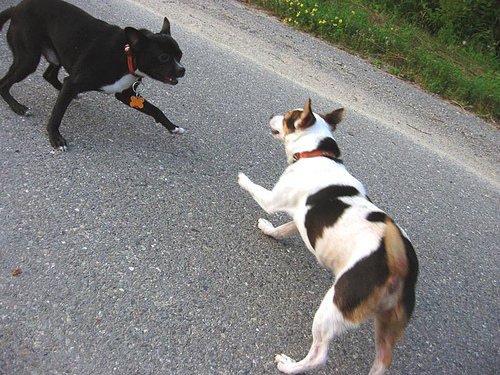

In [ ]:
img =  Image.open("/content/drive/My Drive/Colab Notebooks/ViT/Images/1001773457_577c3a7d70.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:85]+ '\033[0m')

<|endoftext|>A black dog and a white dog are running on a sidewalk. The two dogs are 


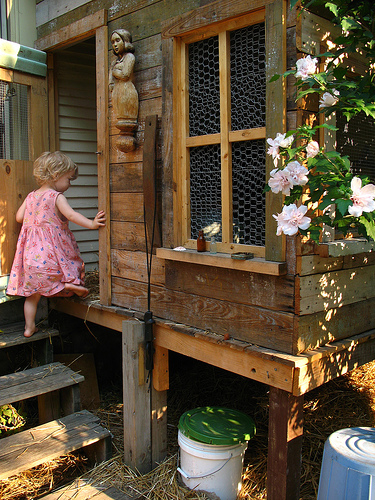

In [ ]:
img =  Image.open("/content/drive/My Drive/Colab Notebooks/ViT/Images/1000268201_693b08cb0e.jpg").convert("RGB")
img

In [ ]:
generated_caption = tokenizer.decode(model.generate(feature_extractor(img, return_tensors="pt").pixel_values.to("cuda"))[0])
print('\033[96m' +generated_caption[:120]+ '\033[0m')

<|endoftext|>A little girl in a pink dress is playing in the yard of a house... a little boy in a blue dress is standing
